In [ ]:
# Set seeds for reproducibility
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

In [ ]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0 # <-- ADD THIS LINE
from tensorflow.keras.optimizers import Adam

In [ ]:
!pip install kaggle

In [ ]:
kaggle_credentails = json.load(open("kaggle.json"))

In [ ]:
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

In [ ]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0

 98% 2.00G/2.04G [00:20<00:01, 38.3MB/s]
100% 2.04G/2.04G [00:20<00:00, 109MB/s] 


In [ ]:
!ls

drive  kaggle.json  plantvillage-dataset.zip  sample_data


In [ ]:
with ZipFile("plantvillage-dataset.zip", 'r') as zip_ref:
  zip_ref.extractall()

In [ ]:
print(os.listdir("plantvillage dataset"))


print(len(os.listdir("plantvillage dataset/segmented")))
print(os.listdir("plantvillage dataset/segmented")[:5])

print(len(os.listdir("plantvillage dataset/color")))
print(os.listdir("plantvillage dataset/color")[:5])

print(len(os.listdir("plantvillage dataset/grayscale")))
print(os.listdir("plantvillage dataset/grayscale")[:5])

['color', 'segmented', 'grayscale']
38
['Tomato___healthy', 'Grape___Esca_(Black_Measles)', 'Corn_(maize)___Common_rust_', 'Tomato___Leaf_Mold', 'Grape___healthy']
38
['Tomato___healthy', 'Grape___Esca_(Black_Measles)', 'Corn_(maize)___Common_rust_', 'Tomato___Leaf_Mold', 'Grape___healthy']
38
['Tomato___healthy', 'Grape___Esca_(Black_Measles)', 'Corn_(maize)___Common_rust_', 'Tomato___Leaf_Mold', 'Grape___healthy']


In [ ]:
print(len(os.listdir("plantvillage dataset/color/Grape___healthy")))
print(os.listdir("plantvillage dataset/color/Grape___healthy")[:5])

423
['72cd93bf-63f6-476a-b3ae-43af2006c9f2___Mt.N.V_HL 6132.JPG', '7e72db84-6afb-408b-b0de-d1b16e9a48af___Mt.N.V_HL 6050.JPG', '8e026e59-ea04-4f21-832c-b7c4539dfe91___Mt.N.V_HL 6096.JPG', 'a23b47a4-048d-4992-bc61-f3adec202543___Mt.N.V_HL 6113.JPG', '92fbe3df-dc85-4e06-8109-3a14f5109b29___Mt.N.V_HL 6173.JPG']


In [ ]:
# Dataset Path
base_dir = 'plantvillage dataset/color'

(256, 256, 3)


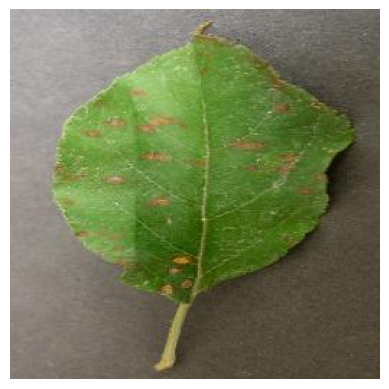

In [ ]:
image_path = '/content/plantvillage dataset/color/Apple___Cedar_apple_rust/025b2b9a-0ec4-4132-96ac-7f2832d0db4a___FREC_C.Rust 3655.JPG'

# Read the image
img = mpimg.imread(image_path)

print(img.shape)
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [ ]:
image_path = '/content/plantvillage dataset/color/Apple___Cedar_apple_rust/025b2b9a-0ec4-4132-96ac-7f2832d0db4a___FREC_C.Rust 3655.JPG'

# Read the image
img = mpimg.imread(image_path)

print(img)

[[[179 175 176]
  [181 177 178]
  [184 180 181]
  ...
  [115 112 105]
  [108 105  98]
  [101  98  91]]

 [[176 172 173]
  [177 173 174]
  [178 174 175]
  ...
  [113 110 103]
  [111 108 101]
  [109 106  99]]

 [[180 176 177]
  [180 176 177]
  [180 176 177]
  ...
  [108 105  98]
  [111 108 101]
  [114 111 104]]

 ...

 [[137 128 119]
  [131 122 113]
  [125 116 107]
  ...
  [ 74  65  48]
  [ 74  65  48]
  [ 73  64  47]]

 [[136 127 118]
  [132 123 114]
  [128 119 110]
  ...
  [ 77  69  50]
  [ 75  67  48]
  [ 75  67  48]]

 [[133 124 115]
  [133 124 115]
  [132 123 114]
  ...
  [ 81  73  54]
  [ 80  72  53]
  [ 79  71  52]]]


In [ ]:
# Image dimensions and batch size
img_size = 224
batch_size = 32

In [ ]:
# Augmented Data Generator
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Train and Validation Generators
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

Found 43456 images belonging to 38 classes.


In [ ]:
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

Found 10849 images belonging to 38 classes.


In [ ]:
# Model Definition using EfficientNetV2B0 for Transfer Learning
# 1. Load the pre-trained EfficientNetV2B0 model
# 'include_top=False' removes the final classification layer from the original model
# 'weights='imagenet'' loads weights pre-trained on the ImageNet dataset
base_model = EfficientNetV2B0(include_top=False,
                              weights='imagenet',
                              input_shape=(img_size, img_size, 3))

# 2. Freeze the layers of the base model
# This prevents the pre-trained weights from being updated during initial training
base_model.trainable = False

# 3. Add your new classification layers on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # A layer to average the spatial features
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax') # The final output layer
])



24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,594,678 (25.16 MB)

 Trainable params: 675,366 (2.58 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
# Compile the model with Adam and a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Callbacks
from tensorflow.keras import layers, models, callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# STAGE 1: Feature Extraction
# Train with the base model frozen.
print("--- Starting Stage 1: Feature Extraction ---")
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,  # Allocate more epochs for the initial training
    callbacks=[early_stop]
)

# STAGE 2: Fine-Tuning
# Unfreeze the base model and re-compile with a low learning rate
print("\n--- Starting Stage 2: Fine-Tuning ---")
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), # Use a very low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training for a few more epochs
history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Allocate fewer epochs for fine-tuning
    callbacks=[early_stop]
)

--- Starting Stage 1: Feature Extraction ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 709s 498ms/step - accuracy: 0.0953 - loss: 3.4096 - val_accuracy: 0.0938 - val_loss: 3.3497
Epoch 2/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 654s 481ms/step - accuracy: 0.0995 - loss: 3.3720 - val_accuracy: 0.1015 - val_loss: 3.3465
Epoch 3/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 659s 485ms/step - accuracy: 0.0974 - loss: 3.3669 - val_accuracy: 0.1015 - val_loss: 3.3415
Epoch 4/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 647s 477ms/step - accuracy: 0.1018 - loss: 3.3612 - val_accuracy: 0.1015 - val_loss: 3.3393
Epoch 5/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 653s 481ms/step - accuracy: 0.1032 - loss: 3.3633 - val_accuracy: 0.1059 - val_loss: 3.3367
Epoch 6/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 659s 485ms/step - accuracy: 0.1034 - loss: 3.3535 - val_accuracy: 0.1018 - val_loss: 3.3331
Epoch 7/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 649s 478ms/step - accuracy: 0.1034 - loss: 3.3506 - val_accuracy: 0.1258 - val_loss: 3.3301
Epoch 8/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 650s 478ms/step - ac

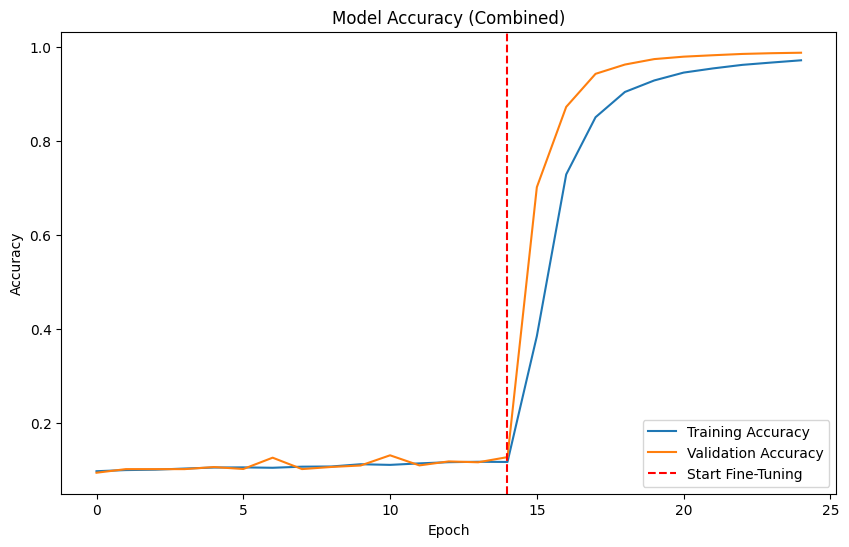

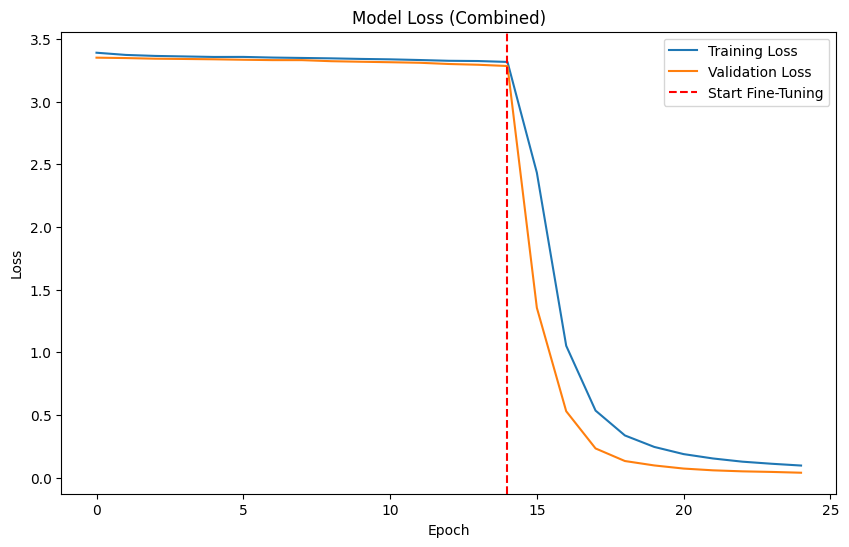

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- Update 1: Plot Combined Training History ---
# We need to combine the history from the initial training and the fine-tuning stage

# Combine the history objects ghfghghgfhgghfgghyuyjhjkhjkdgdcngvbnbbnvbnkjghjgjkkhkh
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Plot combined accuracy
plt.figure(figsize=(10, 6))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# Add a vertical line to show where fine-tuning started
plt.axvline(len(history.history['accuracy']) - 1, color='r', linestyle='--', label='Start Fine-Tuning')
plt.title('Model Accuracy (Combined)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Plot combined loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# Add a vertical line to show where fine-tuning started
plt.axvline(len(history.history['loss']) - 1, color='r', linestyle='--', label='Start Fine-Tuning')
plt.title('Model Loss (Combined)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1. NON-SHUFFLED validation generator
val_eval_gen = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical',
    shuffle=False
)

# 2. Predictions
val_eval_gen.reset()
Y_pred = model.predict(
    val_eval_gen,
    verbose=1   # or steps=int(np.ceil(val_eval_gen.samples / batch_size))
)

y_pred = np.argmax(Y_pred, axis=1)
y_true = val_eval_gen.classes
class_names = list(val_eval_gen.class_indices.keys())

# 3. Classification report
print(classification_report(y_true, y_pred, target_names=class_names))


Found 10849 images belonging to 38 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


340/340 ━━━━━━━━━━━━━━━━━━━━ 142s 399ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.99      0.99       126
                                 Apple___Black_rot       0.99      1.00      1.00       124
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        55
                                   Apple___healthy       0.99      0.99      0.99       329
                               Blueberry___healthy       0.99      1.00      1.00       300
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       210
                 Cherry_(including_sour)___healthy       0.99      0.99      0.99       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.89      0.93      0.91       102
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       238
               Corn_(maize)___Nort

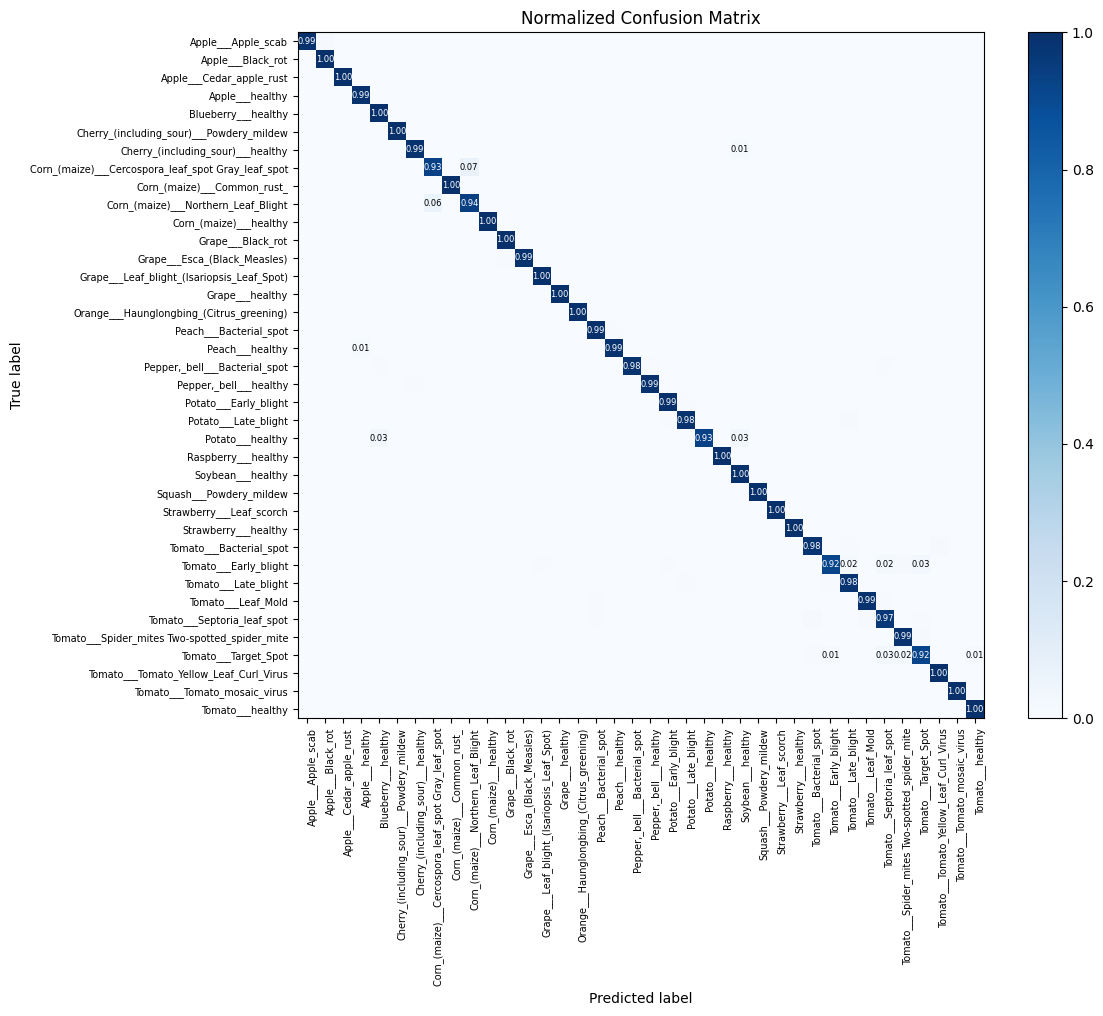

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# 1. Compute confusion matrixmhjkjkj
cm = confusion_matrix(y_true, y_pred)

# 2. Normalize by row (true labels)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# 3. Plot
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Tick labels
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    xlabel='Predicted label',
    ylabel='True label',
    title='Normalized Confusion Matrix'
)

plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor", fontsize=7)
plt.setp(ax.get_yticklabels(), fontsize=7)

# Optional: add values inside boxes (you can comment this out if it looks too crowded)
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        value = cm_norm[i, j]
        if value > 0.01:  # print only meaningful values
            ax.text(j, i, f"{value:.2f}",
                    ha="center", va="center",
                    color="white" if value > thresh else "black",
                    fontsize=6)

fig.tight_layout()

# 4. Save high-res image for PPT
plt.savefig("confusion_matrix_normalized.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Define your dataset path (Make sure this points to where your data is currently unzipped)
# If you used the validation set during training, point to that.
dataset_dir = '/content/plantvillage dataset/color' # Change 'color' to 'grayscale' if you used that

# 2. Re-create the Validation Generator
# We use the same 'rescale' and 'target_size' as you did in training.
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # Assuming 80/20 split

validation_generator = val_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation', # This selects the testing portion of your data
    shuffle=False # Important: Keep false for consistent evaluation
)

# 3. Load your .keras Model (The one that works!)
model_path = 'drive/MyDrive/main_plant/plant_disease_model_v3.keras'
model = tf.keras.models.load_model(model_path)

# 4. Calculate Accuracy
print("Evaluating model...")
loss, accuracy = model.evaluate(validation_generator)

print("------------------------------------------------")
print(f"✅ Overall Model Accuracy: {accuracy * 100:.2f}%")
print(f"📉 Overall Model Loss: {loss:.4f}")
print("------------------------------------------------")

Found 10849 images belonging to 38 classes.
Evaluating model...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


340/340 ━━━━━━━━━━━━━━━━━━━━ 42s 101ms/step - accuracy: 0.9860 - loss: 0.0446
------------------------------------------------
✅ Overall Model Accuracy: 97.96%
📉 Overall Model Loss: 0.0679
------------------------------------------------


In [ ]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

In [ ]:
class_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [ ]:
model.save('drive/MyDrive/main_plant/plant_disease_model_v3.keras')

In [ ]:
import os
# REMOVED THIS LINE: os.environ["TF_USE_LEGACY_KERAS"] = "1"
# (Since you are using .keras format now, you must use standard TensorFlow)

import tensorflow as tf
from PIL import Image
import numpy as np
import io
import json

# --- 1. Load Model and Class Indices ---
model = tf.keras.models.load_model('drive/MyDrive/main_plant/plant_disease_model_v3.keras')

with open('/content/class_indices.json', 'r') as f:
    class_indices = {str(k): v for k, v in json.load(f).items()}

# --- 2. Preprocessing Function ---
def preprocess_image(image_bytes: bytes, target_size=(224, 224)) -> np.ndarray:
    """Converts image bytes to a preprocessed numpy array for the model."""
    img = Image.open(io.BytesIO(image_bytes))
    img = img.resize(target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32') / 255.0
    return img_array

# --- 3. Prediction Function ---
def predict_disease(image_bytes: bytes) -> dict:
    processed_img = preprocess_image(image_bytes)
    prediction = model.predict(processed_img)

    predicted_class_index = str(np.argmax(prediction, axis=1)[0])
    disease_name = class_indices.get(predicted_class_index, "Unknown Disease")
    confidence = float(np.max(prediction))

    return {"disease_name": disease_name, "confidence": confidence}

# --- 4. RUNNING THE TEST (The fix is here) ---
image_path = '/content/plantvillage dataset/grayscale/Apple___Cedar_apple_rust/0340baaa-e9cc-4c04-8f9b-c204180d9ae3___FREC_C.Rust 3805.JPG'

# Read the file as BINARY (bytes) first
with open(image_path, "rb") as image_file:
    image_bytes = image_file.read()

# Now pass the bytes to the function
result = predict_disease(image_bytes)

print("Result:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Result: {'disease_name': 'Tomato___healthy', 'confidence': 0.42362573742866516}
